In [0]:
# Taken from https://github.com/GunhoChoi/AnoGAN-Pytorch

In [0]:
!pip install comet_ml

     |████████████████████████████████| 163kB 3.4MB/s 
     |████████████████████████████████| 389kB 45.0MB/s 
     |████████████████████████████████| 204kB 45.9MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-cp36-none-any.whl size=34546 sha256=da34bff59165616ecc724cb95ca542ac06e0f354f2229f861f3f3e9516f50f34
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj


In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # set gpu number to use

from comet_ml import Experiment

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [0]:
from tqdm import tqdm_notebook as tqdm

# Постановка задачи

Задача поиска аномалий - находить объекты, отличные от нормальных данных

**Примеры:** поиск сбоев, атак, ботов и другого аномального поведения или объектов

Как правило, ***основное отличие задачи поиска аномалий от задачи бинарной классификации*** заключается в том, что ***аномалий*** в выборке ***намного меньше или нет вообще***!

В связи с этим, большинство алгоритмов поиска аномалий, таких как OneClass-SVM и Isolation Forest, основываются на ***гипотезе о компактности***, когда нормальные объекты образуют некоторый кластер или группу кластеров (см. рис. ниже), а аномалии выходят за пределы этих кластеров
![](https://developer.mindsphere.io/apis/analytics-anomalydetection/images/DBSCAN.png)


Для экспериментов будем использовать датасет рукописных цифр MNIST

In [0]:
batch_size = 1000 # по какому количеству объектов выборки будем оценивать градиент 
learning_rate = 0.0002 # скорость обучения (шаг оптимизатора)
num_gpus = 1
anomaly_digit = 0 # какую цифру примем за аномалию

test_each = 2

In [0]:
# Зададим обучающую и тестовую выборки в PyTorch

mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

mnist_test = dset.MNIST("./", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)


train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,batch_size=batch_size,shuffle=True,drop_last=True)

# DataLoader - вспомогательный класс PyTorch, который разбивает данные на батчи

Label: 5


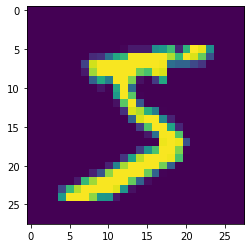

In [0]:
img, label = mnist_train[0] # первый элемент обучающей выборки
print(f'Label: {label}')
plt.imshow(img[0,:,:])

# Baseline
В качестве бейслайна попробуем обучить бинарный классификатор (аномалия/не аномалия) в условиях малого количества аномалий

## Задание 1
Обучите бинарный классификатор для поиска аномалий. Посмотрите на финальный ROC AUC 

In [0]:
class Concat(utils.data.Dataset):

    def __init__(self, datasets):
        self.datasets = datasets
        self.lengths = [len(d) for d in datasets]
        self.offsets = np.cumsum(self.lengths)
        self.length = np.sum(self.lengths)

    def __getitem__(self, index):
        for i, offset in enumerate(self.offsets):
            if index < offset:
                if i > 0:
                    index -= self.offsets[i-1]
                return self.datasets[i][index]
        raise IndexError(f'{index} exceeds {self.length}')

    def __len__(self):
        return self.length

#https://discuss.pytorch.org/t/combine-concat-dataset-instances/1184

In [0]:
not_ano_dataset = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

condition = not_ano_dataset.targets != anomaly_digit
not_ano_dataset.data = not_ano_dataset.data[condition]
not_ano_dataset.targets = not_ano_dataset.targets[condition]


ano_dataset = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

condition = ano_dataset.targets == anomaly_digit
ano_dataset.data = ano_dataset.data[condition][:50]
ano_dataset.targets = ano_dataset.targets[condition][:50]

clf_train_dset = Concat([not_ano_dataset, ano_dataset])
clf_train_loader = torch.utils.data.DataLoader(dataset=clf_train_dset,batch_size=batch_size,shuffle=True,drop_last=True)

In [0]:
# Note: был слишком большой learning rate — понизил в начале файла
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import numpy as np

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(192, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
model = AlexNet(num_classes=2).to('cuda')

criterion = nn.BCEWithLogitsLoss() # бинарная кросс-энтропия 
opt = torch.optim.Adam(model.parameters(), lr=learning_rate,betas=(0.5,0.999)) # оптимизатор

num_anomalies = 50 # количество используемых аномалий. В обучении не должно использоваться больше указанного числа!

def one_hot(batch,depth):
    ones = torch.sparse.torch.eye(depth)
    return ones.index_select(0,batch)

epoch = 30 # сколько циклов обучения (сколько раз прогоним всю обучаюшую выборку в процессе обучения)

# Для построения графичков в конце
losses = []
roc_aucs = []
roc_aucs_test = []

for i in tqdm(range(epoch)):
    used_anomalies = 0

    all_labels = np.array([])
    all_predictions = np.array([])

    for j,(image,label) in tqdm(enumerate(clf_train_loader)):
        opt.zero_grad()

        # Forward pass
        output = model(image.to('cuda')).cpu()
        

        # Готовим one-hot закодированные лейблы
        y = torch.zeros(label.shape[0], 2)
        
        y[:, 1][label == anomaly_digit] = 1 # Положительный класс — это anomaly_digit
        y[:, 0][label != anomaly_digit] = 1 # Отрицательный остальные цифры

        # Evaluation & backward pass
        loss = criterion(output, y)
        loss.backward()
        opt.step()
      

        # Добавляем все для подсчета ROC-AUC в конце эпохи
        if all_labels.shape[0] == 0:
          all_labels = y.detach().numpy()
          all_predictions = F.softmax(output, dim = 1).detach().numpy()
        else:
          all_labels = np.vstack((all_labels, y.detach().numpy()))
          all_predictions = np.vstack((all_predictions, F.softmax(output, dim = 1).detach().numpy()))

    # Проверим перформанс на трейне

    roc_auc = roc_auc_score(all_labels[:, 1], all_predictions[:, 1])

    losses.append(loss.item())
    roc_aucs.append(roc_auc)

    # Проверим перформанс на тесте

    all_labels_test = np.array([])
    all_predictions_test = np.array([])

    if i % 2 == 0:
        for j,(image,label) in tqdm(enumerate(test_loader)):
            output = model(image.to('cuda')).cpu()
            
            # Готовим one-hot закодированные лейблы
            y = torch.zeros(label.shape[0], 2)
            
            y[:, 1][label == anomaly_digit] = 1 # Положительный класс — это anomaly_digit
            y[:, 0][label != anomaly_digit] = 1 # Отрицательный остальные цифры

            # Добавляем все для подсчета ROC-AUC в конце эпохи
            if all_labels_test.shape[0] == 0:
              all_labels_test = y.detach().numpy()
              all_predictions_test = F.softmax(output, dim = 1).detach().numpy()
            else:
              all_labels_test = np.vstack((all_labels_test, y.detach().numpy()))
              all_predictions_test = np.vstack((all_predictions_test, F.softmax(output, dim = 1).detach().numpy()))
 
        roc_auc_test = roc_auc_score(all_labels_test[:, 1], all_predictions_test[:, 1])
        roc_aucs_test.append(roc_auc_test)

        print(f'Epoch: {i}\t Loss: {loss.item()} ROC AUC: {roc_auc} ROC AUC (test): {roc_auc_test}')

    else:
        print(f'Epoch: {i}\t Loss: {loss.item()} ROC AUC: {roc_auc}')

Epoch: 0	 Loss: 0.018368106335401535 ROC AUC: 0.4234902687673773 ROC AUC (test): 0.3192535861351192


Epoch: 1	 Loss: 0.0021977759897708893 ROC AUC: 0.3106991658943466


Epoch: 2	 Loss: 0.0012729042209684849 ROC AUC: 0.3199829471733086 ROC AUC (test): 0.33450998913978003


Epoch: 3	 Loss: 0.008459954522550106 ROC AUC: 0.3470582020389249


Epoch: 4	 Loss: 0.024011332541704178 ROC AUC: 0.39277757182576456 ROC AUC (test): 0.38229931218607177


Epoch: 5	 Loss: 0.008215970359742641 ROC AUC: 0.3789510658016682


Epoch: 6	 Loss: 0.0009181398781947792 ROC AUC: 0.40544541241890636 ROC AUC (test): 0.4292755328295398


Epoch: 7	 Loss: 0.0009641674114391208 ROC AUC: 0.4048274328081557


Epoch: 8	 Loss: 0.000905873195733875 ROC AUC: 0.5166246524559778 ROC AUC (test): 0.47223788406715234


Epoch: 9	 Loss: 0.0009439148707315326 ROC AUC: 0.5013371640407784


Epoch: 10	 Loss: 0.0010320688597857952 ROC AUC: 0.5853614457831325 ROC AUC (test): 0.5291561835377165


Epoch: 11	 Loss: 0.013572714291512966 ROC AUC: 0.5874355885078777


Epoch: 12	 Loss: 0.007355205249041319 ROC AUC: 0.6085434661723819 ROC AUC (test): 0.6003120616317481


Epoch: 13	 Loss: 0.0010331023950129747 ROC AUC: 0.6212693234476367


Epoch: 14	 Loss: 0.0142739312723279 ROC AUC: 0.6575112186076633 ROC AUC (test): 0.6473620412688357


Epoch: 15	 Loss: 0.021655907854437828 ROC AUC: 0.7130120481927711


Epoch: 16	 Loss: 0.0009552902774885297 ROC AUC: 0.8203529193697868 ROC AUC (test): 0.7233939318521199


Epoch: 17	 Loss: 0.0009111181716434658 ROC AUC: 0.7711455050973124


Epoch: 18	 Loss: 0.001133424462750554 ROC AUC: 0.7785193697868396 ROC AUC (test): 0.7693813068464637


Epoch: 19	 Loss: 0.000854683225043118 ROC AUC: 0.8410639481000926


Epoch: 20	 Loss: 0.007091021630913019 ROC AUC: 0.8649560704355885 ROC AUC (test): 0.8180731028553327


Epoch: 21	 Loss: 0.020031964406371117 ROC AUC: 0.8942309545875812


Epoch: 22	 Loss: 0.0009449725039303303 ROC AUC: 0.8942994001737782 ROC AUC (test): 0.8418867369564235


Epoch: 23	 Loss: 0.0007102544186636806 ROC AUC: 0.928668767377201


Epoch: 24	 Loss: 0.0145232193171978 ROC AUC: 0.9216493049119554 ROC AUC (test): 0.8671076745554097


Epoch: 25	 Loss: 0.0008264154312200844 ROC AUC: 0.9288544949026876


Epoch: 26	 Loss: 0.0008166555780917406 ROC AUC: 0.9295903047322986 ROC AUC (test): 0.8892255871306394


Epoch: 27	 Loss: 0.007566625718027353 ROC AUC: 0.9431977757182577


Epoch: 28	 Loss: 0.005956011824309826 ROC AUC: 0.9471588507877664 ROC AUC (test): 0.8976527784062627


Epoch: 29	 Loss: 0.0008963775471784174 ROC AUC: 0.9453265987025024


Text(0.5, 0, 'Epoch')

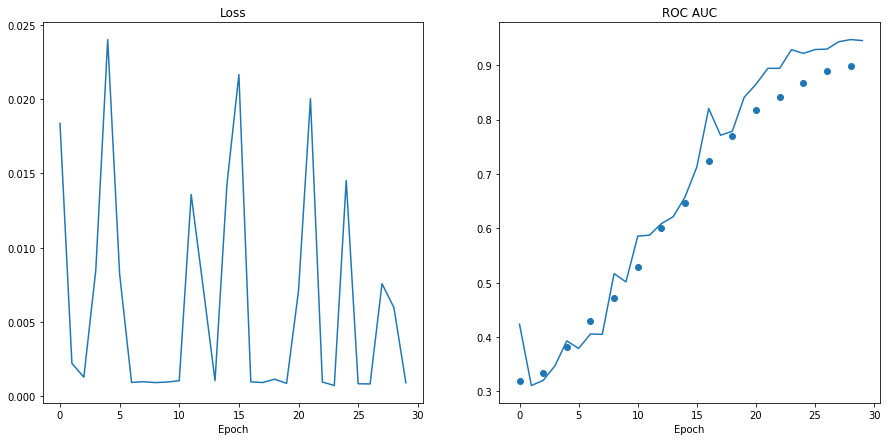

In [0]:
plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(range(epoch),roc_aucs)
plt.scatter(range(0, epoch, 2), roc_aucs_test)
plt.title('ROC AUC')
plt.xlabel('Epoch')

In [0]:
def train_clf(N_of_anomalies):
  not_ano_dataset = dset.MNIST("./", train=True, 
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize([0.5], [0.5]),
                          ]),
                          target_transform=None,
                          download=True)

  condition = not_ano_dataset.targets != anomaly_digit
  not_ano_dataset.data = not_ano_dataset.data[condition]
  not_ano_dataset.targets = not_ano_dataset.targets[condition]


  ano_dataset = dset.MNIST("./", train=True, 
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize([0.5], [0.5]),
                          ]),
                          target_transform=None,
                          download=True)

  condition = ano_dataset.targets == anomaly_digit
  ano_dataset.data = ano_dataset.data[condition][:N_of_anomalies]
  ano_dataset.targets = ano_dataset.targets[condition][:N_of_anomalies]

  clf_train_dset = Concat([not_ano_dataset, ano_dataset])
  clf_train_loader = torch.utils.data.DataLoader(dataset=clf_train_dset,batch_size=batch_size,shuffle=True,drop_last=True)

  class AlexNet(nn.Module):

      def __init__(self, num_classes=1000):
          super(AlexNet, self).__init__()
          self.features = nn.Sequential(
              nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=3, stride=2),
              nn.Conv2d(64, 192, kernel_size=5, padding=2),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=3, stride=2),
  #             nn.Conv2d(192, 384, kernel_size=3, padding=1),
  #             nn.ReLU(inplace=True),
  #             nn.Conv2d(384, 256, kernel_size=3, padding=1),
  #             nn.ReLU(inplace=True),
  #             nn.Conv2d(256, 256, kernel_size=3, padding=1),
  #             nn.ReLU(inplace=True),
  #             nn.MaxPool2d(kernel_size=3, stride=2),
          )
          self.classifier = nn.Sequential(
              nn.Dropout(),
              nn.Linear(192, 4096),
              nn.ReLU(inplace=True),
              nn.Dropout(),
              nn.Linear(4096, 4096),
              nn.ReLU(inplace=True),
              nn.Linear(4096, num_classes),
          )

      def forward(self, x):
          x = self.features(x)
          x = x.view(x.size(0), -1)
          x = self.classifier(x)
          return x
      
  model = AlexNet(num_classes=2).to('cuda')

  criterion = nn.BCEWithLogitsLoss() # бинарная кросс-энтропия 
  opt = torch.optim.Adam(model.parameters(), lr=learning_rate,betas=(0.5,0.999)) # оптимизатор

  num_anomalies = 50 # количество используемых аномалий. В обучении не должно использоваться больше указанного числа!

  def one_hot(batch,depth):
      ones = torch.sparse.torch.eye(depth)
      return ones.index_select(0,batch)

  epoch = 30 # сколько циклов обучения (сколько раз прогоним всю обучаюшую выборку в процессе обучения)

  # Для построения графичков в конце
  losses = []
  roc_aucs = []
  roc_aucs_test = []

  for i in tqdm(range(epoch)):
      used_anomalies = 0

      all_labels = np.array([])
      all_predictions = np.array([])

      for j,(image,label) in tqdm(enumerate(clf_train_loader)):
          opt.zero_grad()

          # Forward pass
          output = model(image.to('cuda')).cpu()
          

          # Готовим one-hot закодированные лейблы
          y = torch.zeros(label.shape[0], 2)
          
          y[:, 1][label == anomaly_digit] = 1 # Положительный класс — это anomaly_digit
          y[:, 0][label != anomaly_digit] = 1 # Отрицательный остальные цифры

          # Evaluation & backward pass
          loss = criterion(output, y)
          loss.backward()
          opt.step()
        

          # Добавляем все для подсчета ROC-AUC в конце эпохи
          if all_labels.shape[0] == 0:
            all_labels = y.detach().numpy()
            all_predictions = F.softmax(output, dim = 1).detach().numpy()
          else:
            all_labels = np.vstack((all_labels, y.detach().numpy()))
            all_predictions = np.vstack((all_predictions, F.softmax(output, dim = 1).detach().numpy()))

      # Проверим перформанс на трейне

      roc_auc = roc_auc_score(all_labels[:, 1], all_predictions[:, 1])

      losses.append(loss.item())
      roc_aucs.append(roc_auc)

      # Проверим перформанс на тесте

      all_labels_test = np.array([])
      all_predictions_test = np.array([])

      if i % 2 == 0:
          print(i)
          for j,(image,label) in tqdm(enumerate(test_loader)):
              output = model(image.to('cuda')).cpu()
              
              # Готовим one-hot закодированные лейблы
              y = torch.zeros(label.shape[0], 2)
              
              y[:, 1][label == anomaly_digit] = 1 # Положительный класс — это anomaly_digit
              y[:, 0][label != anomaly_digit] = 1 # Отрицательный остальные цифры

              # Добавляем все для подсчета ROC-AUC в конце эпохи
              if all_labels_test.shape[0] == 0:
                all_labels_test = y.detach().numpy()
                all_predictions_test = F.softmax(output, dim = 1).detach().numpy()
              else:
                all_labels_test = np.vstack((all_labels_test, y.detach().numpy()))
                all_predictions_test = np.vstack((all_predictions_test, F.softmax(output, dim = 1).detach().numpy()))
  
          roc_auc_test = roc_auc_score(all_labels_test[:, 1], all_predictions_test[:, 1])
          roc_aucs_test.append(roc_auc_test)

  return roc_aucs_test, roc_auc, losses

In [203]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import numpy as np

results = []
for n in [1, 2, 5, 10, 25, 50, 75, 100]:
  print('\t\t\t',n)
  results.append(train_clf(n))

			 1


0


2


4


6


8


10


12


14


16


18


20


22


24


26


28


			 2


0


2


4


6


8


10


12


14


16


18


20


22


24


26


28


			 5


0


2


4


6


8


10


12


14


16


18


20


22


24


26


28


			 10


0


2


4


6


8


10


12


14


16


18


20


22


24


26


28


			 25


0


2


4


6


8


10


12


14


16


18


20


22


24


26


28


			 50


0


2


4


6


8


10


12


14


16


18


20


22


24


26


28


			 75


0


2


4


6


8


10


12


14


16


18


20


22


24


26


28


			 100


0


2


4


6


8


10


12


14


16


18


20


22


24


26


28


# AnoGAN

Основная идея [AnoGAN](https://arxiv.org/abs/1703.05921) - находить аномалии на основе расстояния до ближайшего соседа в пространстве латентных переменных. Алгоритм состоит из двух этапов:
1. На первом этапе обучается дискриминатор и генератор в стандартном режиме на нормальных объектах. При этом предполается, что генератор выучивает некоторое преобразование из латентного многообразия Z в пространство нормальных объектов
2. На втором этапе для каждого нового объекта считается расстояние до латентного многообразия, в котором сконцентрированы нормальные объекты. Те объекты, расстояние от которых до многообразия слишком большое, принимаются за аномалии

![](https://i.ibb.co/ZmzwMfS/image.png)

# AnoGAN. Этап 1. Обучение генератора на нормальных объектах

In [0]:
not_ano_dataset = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

condition = not_ano_dataset.targets != anomaly_digit
not_ano_dataset.data = not_ano_dataset.data[condition]
not_ano_dataset.targets = not_ano_dataset.targets[condition]

not_ano_loader = torch.utils.data.DataLoader(dataset=not_ano_dataset,batch_size=batch_size,shuffle=True,drop_last=True)

In [0]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [0]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3,stride=2,padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        #('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        #nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out

In [0]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

## Задание 2
Обучите GAN любым удобным вам способом

**Внимание:** обучайте GAN только на **нормальных** объектах (цифрах)!

In [0]:
import torch.autograd as autograd

def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.cuda.FloatTensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(torch.cuda.FloatTensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [0]:
import torch
from torchvision.utils import make_grid

def run_an_experiment(lr, n_epochs,
                          lambda_gp, n_critic, sample_interval):
    experiment = Experiment(api_key = 'fcQ6lceLdmViH5KysjfD4mkz7', project_name='AnoGAN', workspace='Sirius-yandex-2019')
    
    experiment.log_parameter('n_epochs', n_epochs)
    experiment.log_parameter('n_critic', n_critic)
    experiment.log_parameter('lr', lr)

    generator = Generator().cuda()
    discriminator = Discriminator().cuda()

    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    Tensor = torch.cuda.FloatTensor

    batches_done = 0

    for epoch in range(n_epochs):

        for i, (imgs, _) in enumerate(not_ano_loader):

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

            # Generate a batch of images
            fake_imgs = generator(z.to('cuda'))

            # Real images
            real_validity = discriminator(real_imgs)
            # Fake images
            fake_validity = discriminator(fake_imgs)
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
            # Adversarial loss
            loss_D = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

            loss_D.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            # Train the generator every n_critic iterations
            if i % n_critic == 0:

                # -----------------
                #  Train Generator
                # -----------------

                # Generate a batch of images
                gen_imgs = generator(z)
                # Adversarial loss
                loss_G = -torch.mean(discriminator(gen_imgs))

                loss_G.backward()
                optimizer_G.step()

                print(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                    % (epoch, n_epochs, batches_done % len(not_ano_loader), len(not_ano_loader), loss_D.item(), loss_G.item())
                )

                experiment.log_metrics({'G': loss_G.item(), 'D': loss_D.item()}, epoch = epoch, step = batches_done)

            if batches_done % sample_interval == 0:
                plt.figure(figsize = (15,10))
                plt.imshow(make_grid(gen_imgs.data[:25]).cpu().detach().numpy()[0, :, :])
                experiment.log_figure()
                plt.close('all')

            batches_done += 1

    experiment.end()

In [0]:
for lr in [0.0001, 0.00001, 0.001]:
  for n_crit in [3, 1, 2, 5, 10]:
      run_an_experiment(lr, 10, 10, n_crit, 10)

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan/f8e6fe00ea924a05bafa1a7eb0c6d9d0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     D [4]                    : (-0.676028847694397, 1.4382230043411255)
COMET INFO:     G [4]                    : (-0.18891166150569916, -0.04173518344759941)
COMET INFO:     loss [3]                 : (-0.7353069186210632, 1.4382230043411255)
COMET INFO:     sys.cpu.percent.01       : (2.7, 2.7)
COMET INFO:     sys.cpu.percent.02       : (2.7, 2.7)
COMET INFO:     sys.cpu.percent.avg      : (2.7, 2.7)
COMET INFO:     sys.gpu.0.free_memory    : (773652480.0, 773652480.0)
COMET INFO:     sys.gpu.0.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory   : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory    : (11223302144.0, 11223302144.0)
COMET INFO:     sys.ram.total            : (13655236608.0, 13655

[Epoch 0/10] [Batch 0/54] [D loss: 0.584655] [G loss: 0.013807]
[Epoch 0/10] [Batch 3/54] [D loss: 0.201791] [G loss: -0.136450]
[Epoch 0/10] [Batch 6/54] [D loss: -0.079071] [G loss: -0.213963]
[Epoch 0/10] [Batch 9/54] [D loss: -0.360601] [G loss: -0.206184]
[Epoch 0/10] [Batch 12/54] [D loss: -0.604493] [G loss: -0.178688]
[Epoch 0/10] [Batch 15/54] [D loss: -0.892827] [G loss: -0.100769]
[Epoch 0/10] [Batch 18/54] [D loss: -1.079830] [G loss: -0.060143]
[Epoch 0/10] [Batch 21/54] [D loss: -1.276672] [G loss: -0.086105]
[Epoch 0/10] [Batch 24/54] [D loss: -1.428790] [G loss: -0.108803]
[Epoch 0/10] [Batch 27/54] [D loss: -1.541697] [G loss: -0.141886]
[Epoch 0/10] [Batch 30/54] [D loss: -1.762748] [G loss: -0.123101]
[Epoch 0/10] [Batch 33/54] [D loss: -1.957435] [G loss: -0.060531]
[Epoch 0/10] [Batch 36/54] [D loss: -2.149966] [G loss: -0.009753]
[Epoch 0/10] [Batch 39/54] [D loss: -2.365980] [G loss: 0.074838]
[Epoch 0/10] [Batch 42/54] [D loss: -2.631039] [G loss: 0.197622]
[Epo

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan/fbbc5dfab1a04df88906704b65ded79f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     D [180]                       : (-125.00921630859375, 0.584654688835144)
COMET INFO:     G [180]                       : (-0.213963121175766, 30.691591262817383)
COMET INFO:     loss [72]                     : (-122.54097747802734, 26.611370086669922)
COMET INFO:     sys.cpu.percent.01 [14]       : (34.6, 83.6)
COMET INFO:     sys.cpu.percent.02 [14]       : (11.9, 28.7)
COMET INFO:     sys.cpu.percent.avg [14]      : (23.25, 52.55)
COMET INFO:     sys.gpu.0.free_memory [16]    : (767361024.0, 771555328.0)
COMET INFO:     sys.gpu.0.gpu_utilization [16]: (0.0, 99.0)
COMET INFO:     sys.gpu.0.total_memory        : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory [16]    : (11225399296.0, 11229593600.0)
COMET INF

[Epoch 0/10] [Batch 0/54] [D loss: 2.382686] [G loss: -0.154959]
[Epoch 0/10] [Batch 1/54] [D loss: 2.062944] [G loss: -0.311745]
[Epoch 0/10] [Batch 2/54] [D loss: 1.711726] [G loss: -0.489871]
[Epoch 0/10] [Batch 3/54] [D loss: 1.536785] [G loss: -0.644049]
[Epoch 0/10] [Batch 4/54] [D loss: 1.479353] [G loss: -0.755423]
[Epoch 0/10] [Batch 5/54] [D loss: 1.281494] [G loss: -0.826304]
[Epoch 0/10] [Batch 6/54] [D loss: 1.088808] [G loss: -0.865431]
[Epoch 0/10] [Batch 7/54] [D loss: 0.856704] [G loss: -0.855305]
[Epoch 0/10] [Batch 8/54] [D loss: 0.830059] [G loss: -0.849566]
[Epoch 0/10] [Batch 9/54] [D loss: 0.658291] [G loss: -0.812193]
[Epoch 0/10] [Batch 10/54] [D loss: 0.526993] [G loss: -0.796556]
[Epoch 0/10] [Batch 11/54] [D loss: 0.427233] [G loss: -0.784866]
[Epoch 0/10] [Batch 12/54] [D loss: 0.357832] [G loss: -0.760085]
[Epoch 0/10] [Batch 13/54] [D loss: 0.276187] [G loss: -0.723065]
[Epoch 0/10] [Batch 14/54] [D loss: 0.159644] [G loss: -0.678280]
[Epoch 0/10] [Batch 

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan/8b37e7d523bf42508ec85d93cd4d147a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     D [540]                       : (-9.424703598022461, 2.3826863765716553)
COMET INFO:     G [540]                       : (-4.557084083557129, 3.3231375217437744)
COMET INFO:     loss [108]                    : (-9.424703598022461, 3.192014694213867)
COMET INFO:     sys.cpu.percent.01 [20]       : (44.2, 83.9)
COMET INFO:     sys.cpu.percent.02 [20]       : (16.7, 60.7)
COMET INFO:     sys.cpu.percent.avg [20]      : (46.5, 52.7)
COMET INFO:     sys.gpu.0.free_memory [23]    : (767361024.0, 767361024.0)
COMET INFO:     sys.gpu.0.gpu_utilization [23]: (0.0, 98.0)
COMET INFO:     sys.gpu.0.total_memory        : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory [23]    : (11229593600.0, 11229593600.0)
COMET INFO:  

[Epoch 9/10] [Batch 53/54] [D loss: -0.425447] [G loss: -4.234559]


COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sirius-yandex-2019/anogan/9e0cd56abfa94a7aa79b53f05ffcfd85



[Epoch 0/10] [Batch 0/54] [D loss: 1.454056] [G loss: -0.010750]
[Epoch 0/10] [Batch 2/54] [D loss: 1.157662] [G loss: -0.212235]
[Epoch 0/10] [Batch 4/54] [D loss: 0.833991] [G loss: -0.336458]
[Epoch 0/10] [Batch 6/54] [D loss: 0.562328] [G loss: -0.408381]
[Epoch 0/10] [Batch 8/54] [D loss: 0.316219] [G loss: -0.429809]
[Epoch 0/10] [Batch 10/54] [D loss: 0.073503] [G loss: -0.417629]
[Epoch 0/10] [Batch 12/54] [D loss: -0.132515] [G loss: -0.383359]
[Epoch 0/10] [Batch 14/54] [D loss: -0.304117] [G loss: -0.360950]
[Epoch 0/10] [Batch 16/54] [D loss: -0.398945] [G loss: -0.347988]
[Epoch 0/10] [Batch 18/54] [D loss: -0.535823] [G loss: -0.331850]
[Epoch 0/10] [Batch 20/54] [D loss: -0.653666] [G loss: -0.301183]
[Epoch 0/10] [Batch 22/54] [D loss: -0.765308] [G loss: -0.291196]
[Epoch 0/10] [Batch 24/54] [D loss: -0.924348] [G loss: -0.237673]
[Epoch 0/10] [Batch 26/54] [D loss: -1.004290] [G loss: -0.190650]
[Epoch 0/10] [Batch 28/54] [D loss: -1.185551] [G loss: -0.113125]
[Epoch

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan/9e0cd56abfa94a7aa79b53f05ffcfd85
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     D [270]                       : (-167.76806640625, 1.4540560245513916)
COMET INFO:     G [270]                       : (-0.42980867624282837, 82.65509796142578)
COMET INFO:     loss [54]                     : (-162.11422729492188, 1.4540560245513916)
COMET INFO:     sys.cpu.percent.01 [15]       : (15.9, 85.0)
COMET INFO:     sys.cpu.percent.02 [15]       : (20.2, 81.5)
COMET INFO:     sys.cpu.percent.avg [15]      : (48.7, 52.6)
COMET INFO:     sys.gpu.0.free_memory [17]    : (767361024.0, 767361024.0)
COMET INFO:     sys.gpu.0.gpu_utilization [17]: (0.0, 98.0)
COMET INFO:     sys.gpu.0.total_memory        : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory [17]    : (11229593600.0, 11229593600.0)
COMET INFO: 

[Epoch 0/10] [Batch 0/54] [D loss: 0.151967] [G loss: -0.235945]
[Epoch 0/10] [Batch 5/54] [D loss: -0.254330] [G loss: -0.297118]
[Epoch 0/10] [Batch 10/54] [D loss: -0.715204] [G loss: -0.239440]
[Epoch 0/10] [Batch 15/54] [D loss: -1.174852] [G loss: -0.175759]
[Epoch 0/10] [Batch 20/54] [D loss: -1.569104] [G loss: -0.154214]
[Epoch 0/10] [Batch 25/54] [D loss: -1.954344] [G loss: -0.074636]
[Epoch 0/10] [Batch 30/54] [D loss: -2.290030] [G loss: 0.027819]
[Epoch 0/10] [Batch 35/54] [D loss: -2.595940] [G loss: 0.102990]
[Epoch 0/10] [Batch 40/54] [D loss: -2.945808] [G loss: 0.263902]


## AnoGAN. Этап 2. Подсчёт расстояния до нормальных объектов и подбор 

## Задание 3
Реализуйте расстояние до аномалий согласно формуле, предложенной в [статье](https://arxiv.org/abs/1703.05921):
$$L(x,G_z)=(1-\lambda)|x-G_z| + \lambda|D(x)-D(G_z)|$$, где x - аномалия (или нормальный объект), $G_z=G(z)$ - объект, сгенерированный генератором $G$ из латентного представления $z\in Z$

In [0]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x,G_z, D, Lambda=0.1): # расстояние до аномалии x до G_z. На выходе должен возвращаться тензор (batch_size,)
    return (1-Lambda) * torch.sum(torch.abs(x-G_z), dim = [2,3])+ Lambda*torch.abs(D(x) - D(G_z))

In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

start_idx = 64
train_size = 500


train_data_mnist = mnist_train.__dict__['data'][start_idx:start_idx+train_size]
train_label_mnist = mnist_train.__dict__['targets'][start_idx:start_idx+train_size] == anomaly_digit # 0 - нормальный объект, 1 - аномалия
train_data_mnist = train_data_mnist.view(train_size,1,28,28).type_as(torch.FloatTensor())
train_data_mnist.size()

torch.Size([500, 1, 28, 28])

## Задание 4
Теперь, имея расстояние между двумя объектами, найдите ближайших соседей в латентном пространстве $Z$ для каждого из объектов выборки train_data_mnist. Поиск ближайшего соседа для каждого из объектов производится путём градиентной минимизации расстояния по переменной $z$.

Имея теперь расстояние до ближайшего соседа для каждого объекта выборки train_data_mnist, можно интерпретировать это расстояние как скор модели - чем больше это расстояние, тем больше вероятность, что ваш объект - аномалия, и наоборот.

Посмотрите, как по мере обучения (по мере поиска ближайшего соседа) меняется это расстояние. Принимая это расстояние за скор модели, посмотрите, как по мере обучения меняется ROC AUC. Сравните результат с baseline. Стало ли лучше?

In [0]:
z = Variable(init.normal(torch.zeros(train_size,100),mean=0,std=0.1),requires_grad=True) # для каждого объекта берём случайный нормальный объект в латентном пространстве в качестве начального соседа
z_optimizer = torch.optim.Adam([z],lr=1) # задаём оптимизатор для поиска ближайшего z к нашим аномалиям

gen_fake = gen(z.cuda())
loss = Anomaly_score(Variable(train_data_mnist).cuda(),gen_fake, disc) # расстояние до нормального соседа. Путём минимизации этого расстояния будем находить расстояние до ближайшего соседа
print(loss.shape)
print(loss.mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """Entry point for launching an IPython kernel.


torch.Size([500, 1])
tensor(23281.7734, device='cuda:0', grad_fn=<MeanBackward0>)


In [0]:
losses_z = []

z_optimizer = torch.optim.Adam([z],lr=1e-2) # задаём оптимизатор для поиска ближайшего z к нашим аномалиям

for i in tqdm(range(1000)):
  z_optimizer.zero_grad()
  gen_fake = gen(z.cuda())
  loss = Anomaly_score(Variable(train_data_mnist).cuda(),gen_fake, disc, 0.7).mean() # расстояние до нормального соседа. Путём минимизации этого расстояния будем находить расстояние до ближайшего соседа
  loss.backward()
  z_optimizer.step()
  losses_z.append(loss.item())


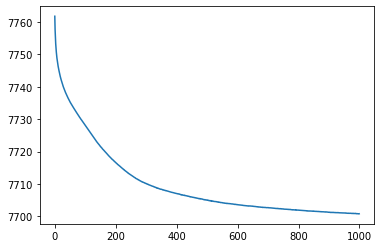

In [0]:
plt.plot(losses_z)

In [0]:
(not_ano_loader.dataset.targets == 0).any()

tensor(False)

## Задание 5
Посмотрим на ближайших соседей

False


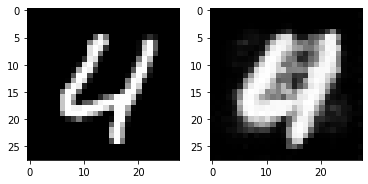

/n/n/
False


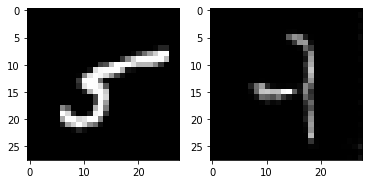

/n/n/
False


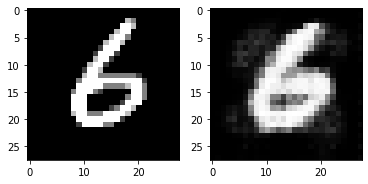

/n/n/
False


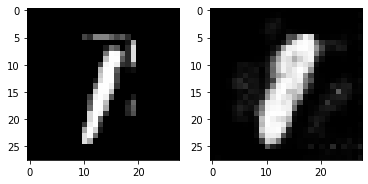

/n/n/
True


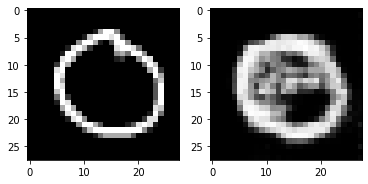

/n/n/
True


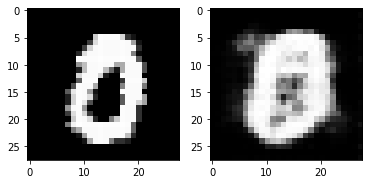

/n/n/
False


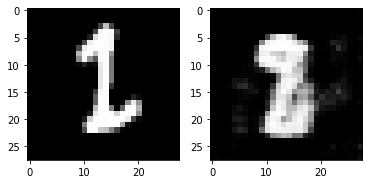

/n/n/
False


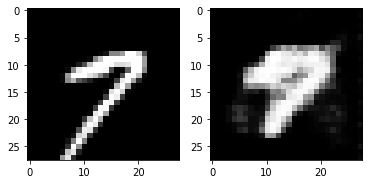

/n/n/
False


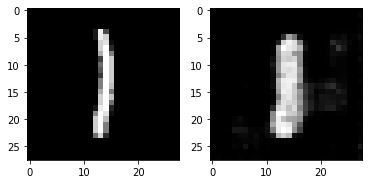

/n/n/
False


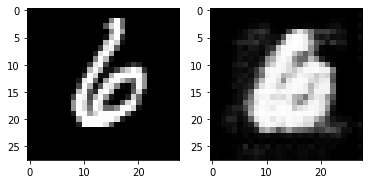

/n/n/


In [0]:
fake_imgs = gen(z.cuda())
for i in range(10):
  print(train_label_mnist[i].item())

  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(train_data_mnist.cpu().detach().numpy()[i][0], cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(fake_imgs.cpu().detach().numpy()[i][0], cmap='gray')
  plt.show()

  print('/n/n/')

## Задание 6
Построим распределение расстояний для нормальных и аномальных объектов.
Что можно сказать, глядя на это распределение?

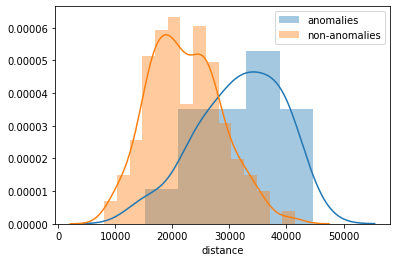

In [0]:
%matplotlib inline
import seaborn as sns
loss = Anomaly_score(Variable(train_data_mnist).cuda(),fake_imgs, disc)

sns.distplot(loss[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.legend()

In [0]:
from sklearn.metrics import roc_auc_score

roc_auc_score(train_label_mnist.detach().cpu().numpy(), loss.detach().cpu().numpy())

0.8321810471976402

In [0]:
import dill
dill.dump_session('/gdrive/My Drive/AnoGAN_MNIST 2019-11-06_wtih many numbers.db')

## Задание 7 (*)
Попробуйте обучить baseline (классификатор) на большем количестве аномалий. Стал ли классификатор работать лучше AnoGAN и, если да, с какого момента?

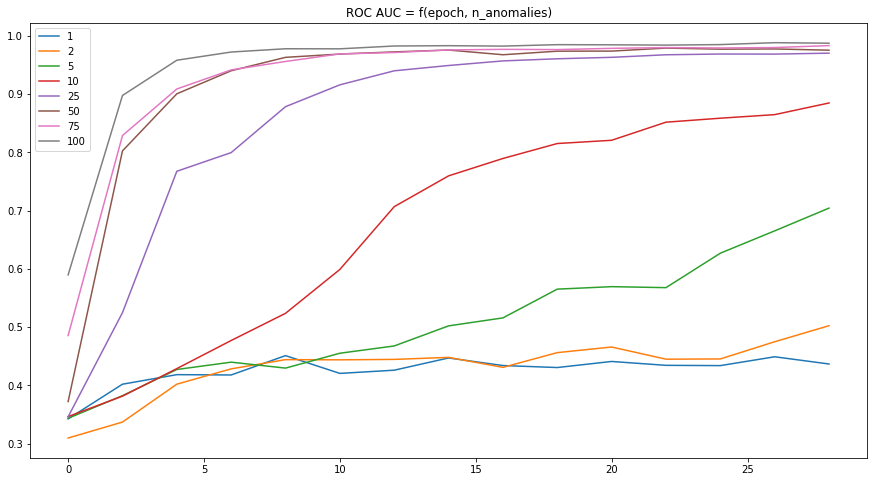

In [204]:
plt.figure(figsize = (15,8))
for ind, res in enumerate(results):
  plt.plot(range(0, 30, 2), res[0], label = [1, 2, 5, 10, 25, 50, 75, 100][ind])
plt.title('ROC AUC = f(epoch, n_anomalies)')
plt.legend()

Text(0, 0.5, 'ROC AUC score (30 epochs)')

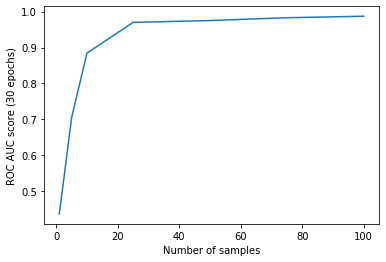

In [212]:
plt.plot([1, 2, 5, 10, 25, 50, 75, 100], [res[0][-1] for res in results])
plt.xlabel('Number of samples')
plt.ylabel('ROC AUC score (30 epochs)')